# Détection des faux Billets

Votre société de consulting informatique vous propose une nouvelle mission : créer un algorithme de détection de faux billets.

Le [jeu de données](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/notes.csv)  contenant les caractéristiques géométriques de billets de banque. Pour chacun d'eux, nous connaissons :

 - la longueur du billet (en mm) ;  
 - la hauteur du billet (mesurée sur le côté gauche, en mm) ;  
 - La hauteur du billet (mesurée sur le côté droit, en mm) ;  
 - la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ;  
 - la marge entre le bord inférieur du billet et l'image de celui-ci (en mm) ;  
 - la diagonale du billet (en mm).

L'étude va consister en 3 parties : 

Partie 1 : analyse exploratoire univariée et bivariée de votre jeu de données  
Partie 2 : ACP 
    Vous réaliserez une analyse en composantes principales de l'échantillon, en suivant toutes ces étapes :  

analyse de l'éboulis des valeurs propres ;
représentation des variables par le cercle des corrélations ;
représentation des individus par les plans factoriels ;
analyser de la qualité de représentation et la contribution des individus.
Pour chacune de ces étapes, commentez les résultats obtenus. La variable donnant la nature Vrai/Faux du billet sera utilisée comme variable illustrative.

Si besoin de compléments sur l'ACP, n'hésitez pas à vous référez à [cours](https://openclassrooms.com/fr/courses/4525281-realisez-une-analyse-exploratoire-de-donnees/5280368-comprenez-lenjeu-de-lanalyse-en-composantes-principales) si besoin pour la partie plus théorique

Partie 3 : Réaliser une classification des billets (révisions de kmeans ou régression logique, et aller creuser côté CAH)

In [50]:
# Import des librairies
import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import sklearn
#classe pour l'ACP
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics


from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram
import scipy.stats as scs
from scipy.stats import ks_2samp

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools import add_constant
from statsmodels.api import Logit

from math import pi

## Partie 0 : ANALYSES BIVARIES

Dans cette partie, vous allez explorer vos données via des visualisations, par exemple :   
    
    - le nombre de billets vrai/faux  
    - les distributions de longueurs, largeurs and co des billets de votre dataset
    - longueur/largeur and co des billets vrais vs. faux
    - etc -> be creative :)

In [51]:
notes=pd.read_csv("./notes.csv")

In [52]:
notes.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


In [53]:
notes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    170 non-null    bool   
 1   diagonal      170 non-null    float64
 2   height_left   170 non-null    float64
 3   height_right  170 non-null    float64
 4   margin_low    170 non-null    float64
 5   margin_up     170 non-null    float64
 6   length        170 non-null    float64
dtypes: bool(1), float64(6)
memory usage: 8.3 KB


In [54]:
notes.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500
max,173.010000,104.860000,104.950000,6.280000,3.680000,113.980000


In [55]:
notes.shape

(170, 7)

In [56]:
notes.columns.values

array(['is_genuine', 'diagonal', 'height_left', 'height_right',
       'margin_low', 'margin_up', 'length'], dtype=object)

In [57]:
notes['is_genuine'].unique()

array([ True, False])

In [58]:
notes['is_genuine'].value_counts()

True     100
False     70
Name: is_genuine, dtype: int64

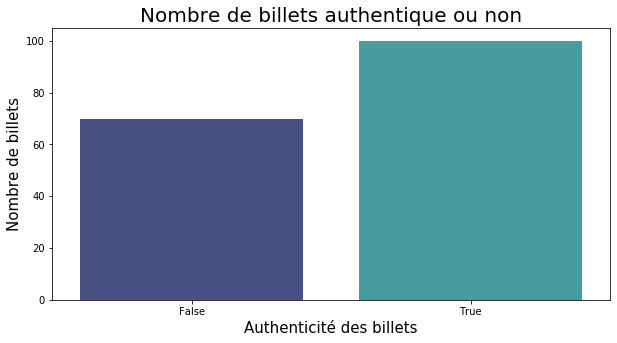

In [59]:
plt.figure(figsize=(10,5))
sns.countplot(x='is_genuine', data=notes, palette='mako')
plt.xlabel('Authenticité des billets',fontsize=15)
plt.ylabel("Nombre de billets",fontsize=15)
plt.title("Nombre de billets authentique ou non",fontsize=20)
plt.show()

In [60]:
Faux = len(notes[notes['is_genuine']==False])
Vrai = len(notes[notes['is_genuine']==True])

nbr_Vrai = Faux/(Faux+Vrai)
print("Pourcentage de billets faux :", nbr_Vrai * 100)

nbr_Faux = Vrai/(Faux+Vrai)
print("Pourcentage de billets vrai :", nbr_Faux * 100)

Pourcentage de billets faux : 41.17647058823529
Pourcentage de billets vrai : 58.82352941176471


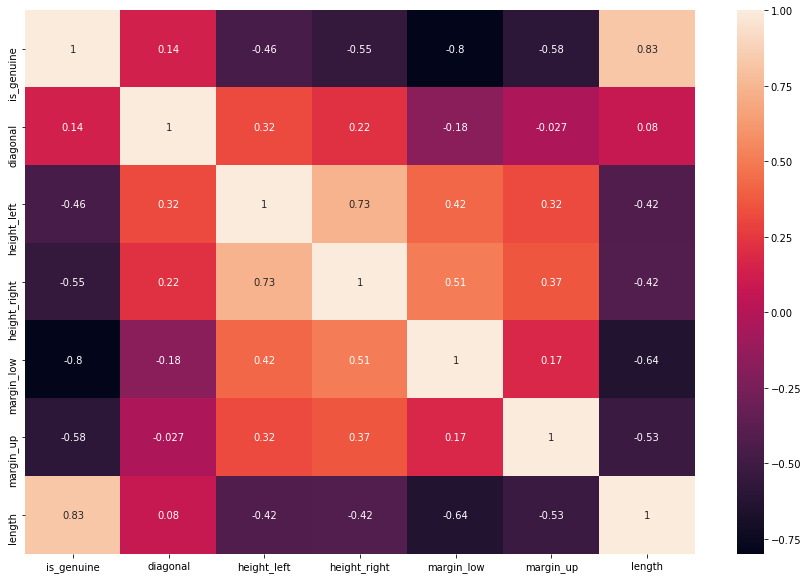

In [61]:
plt.figure(figsize=(15,10))
sns.heatmap (notes.corr(), annot = True)

In [62]:
#sns.pairplot(notes)

Text(0, 0.5, 'height_right')

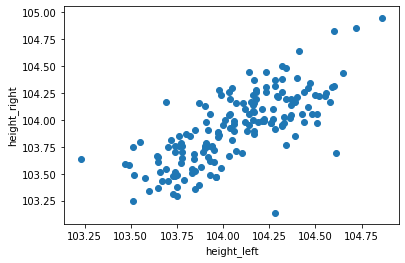

In [63]:
plt.scatter(notes['height_left'], notes['height_right'])
plt.xlabel('height_left')
plt.ylabel('height_right')

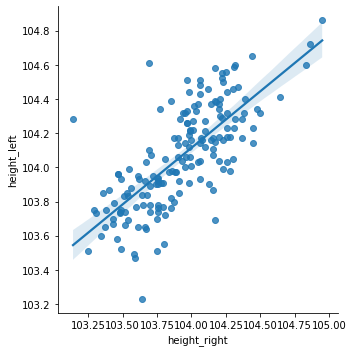

In [64]:
sns.lmplot(x='height_right', y='height_left', data=notes)

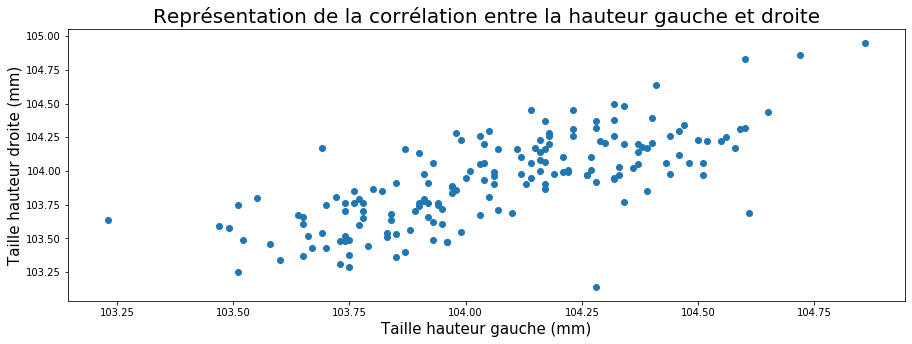

In [65]:
#import fonctions as f

X = notes.height_left
Y = notes.height_right

#fitLine = f.predict(X, X, Y)

plt.figure(figsize=(15,5))
axes = plt.axes()
axes.grid() 
plt.scatter(X,Y)

plt.xlabel('Taille hauteur gauche (mm)',fontsize=15)
plt.ylabel("Taille hauteur droite (mm)",fontsize=15)
plt.title("Représentation de la corrélation entre la hauteur gauche et droite",fontsize=20)
plt.grid(False)

plt.show()

In [66]:
notes.groupby(by='is_genuine').mean()

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,171.889857,104.230429,104.145571,5.281571,3.334571,111.660714
True,171.976100,103.951500,103.775900,4.143500,3.055500,113.207200


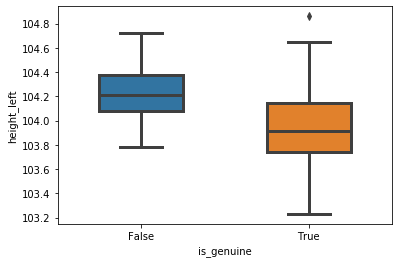

In [67]:
sns.boxplot( x=notes["is_genuine"], y=notes["height_left"], linewidth=3, width = 0.5)

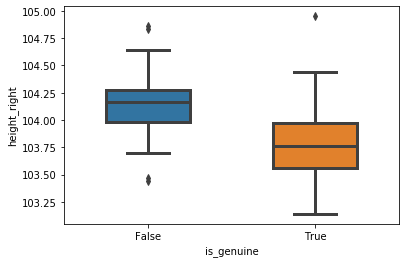

In [68]:
sns.boxplot( x=notes["is_genuine"], y=notes["height_right"], linewidth=3, width = 0.5)

In [69]:
#df = pd.DataFrame(notes.drop('is_genuine',axis=1))
#df = pd.DataFrame(notes)
#df.is_genuine = [1 if i == True else 0 for i in df.is_genuine]

## Partie 1 : ANALYSE EN COMPOSANTES PRINCIPALES

Repartez de l'exploration via l'étude VISA pour cette partie + le cours sur OC
Dans tous les cas, je veux voir : 
    - un diagramme ebouli pour expliquer le pourcentage d'inertie de vos composantes principales
    - un cercle des corrélations de vos variables + l'interprétation de celui-ci
    - représentaiton des individus (= des billets) sur le plan factoriel

In [70]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
# définition de la commande
pca = PCA()
# Sélection des variables quantitatives
dat=notes[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]
data = pd.DataFrame(scale(dat),columns=dat.columns)


In [71]:
# réduction
X_scaled = pd.DataFrame(scale(dat),columns=dat.columns)
# composantes principales
C = pca.fit(data).transform(data)
C

array([[ 2.15363875,  1.59970945,  1.78745079,  2.43346523,  0.69968952,
        -1.26770217],
       [-2.11041589, -0.52603892,  0.54256277,  0.34454951,  0.0674404 ,
        -0.54460079],
       [-1.97315242, -0.04810178,  0.85871563,  0.37481231, -0.4248861 ,
         0.08048667],
       ...,
       [ 2.06724502,  0.84560244, -0.61028227, -1.71417169,  0.1169579 ,
        -0.50433787],
       [ 0.73925685, -0.97296457, -1.35977212, -0.19173617, -0.24355701,
         0.21142914],
       [ 1.50499242, -1.07972486,  0.18888855, -1.34755225, -0.2891493 ,
        -0.06034599]])

In [72]:
#passage des labels en numérique
notes.is_genuine = notes.is_genuine.apply(lambda x:
                                              "0" if x=="True"
                                              else "1" if x=="False"
                                              else "NAN")
notes.is_genuine = notes.is_genuine.astype("float")
notes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    0 non-null      float64
 1   diagonal      170 non-null    float64
 2   height_left   170 non-null    float64
 3   height_right  170 non-null    float64
 4   margin_low    170 non-null    float64
 5   margin_up     170 non-null    float64
 6   length        170 non-null    float64
dtypes: float64(7)
memory usage: 9.4 KB


In [73]:
notes['is_genuine'] = notes['is_genuine'].astype('category').cat.codes

# Éboulis des valeurs propres

Nous allons dans un premier temps faire un éboulis des valeurs propre, pour voir combien d'axes étudier.


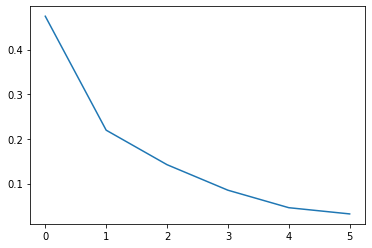

In [74]:
# Eboulis des valeurs propres
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.show()

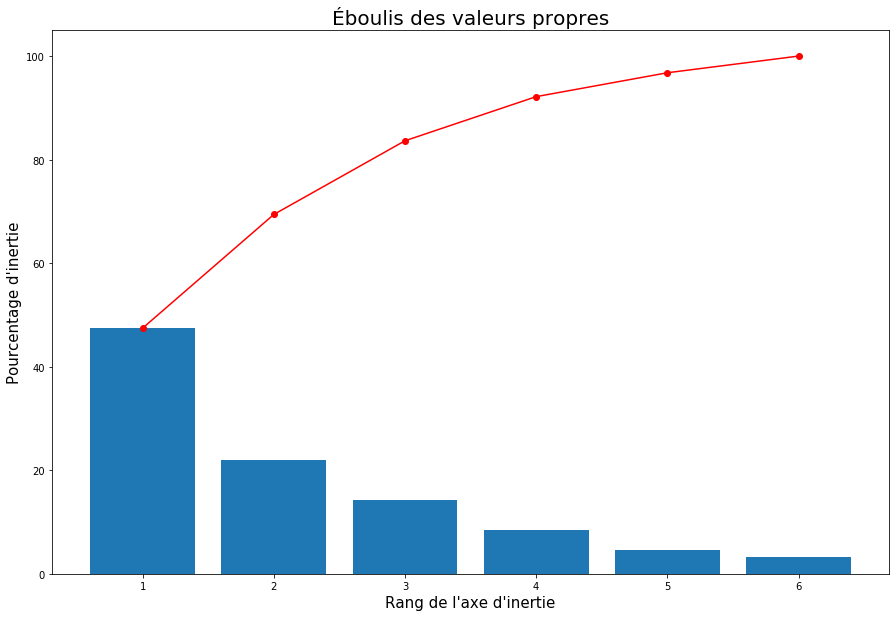

In [75]:
plt.figure(figsize=(15,10))

scree = pca.explained_variance_ratio_*100

plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')

plt.xlabel("Rang de l'axe d'inertie", fontsize=15)
plt.ylabel("Pourcentage d'inertie", fontsize=15)
plt.title("Éboulis des valeurs propres",fontsize=20)

plt.show()

In [96]:
scree = pd.DataFrame(scree.round(3), index=('Axe 1','Axe 2','Axe 3','Axe 4','Axe 5'))
scree.columns = ['Inertie %']
scree

,Inertie %
Axe 1,70.119
Axe 2,14.020
Axe 3,9.083
Axe 4,3.638
Axe 5,1.740


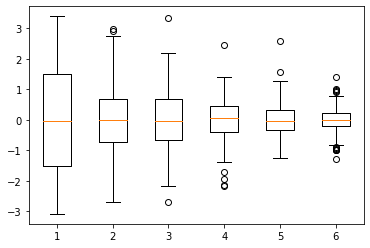

In [76]:
# Diagrammes boîte des composantes principales
plt.figure()
plt.boxplot(C[:,0:20])
plt.show()


# Cercle de corrélation des variables.

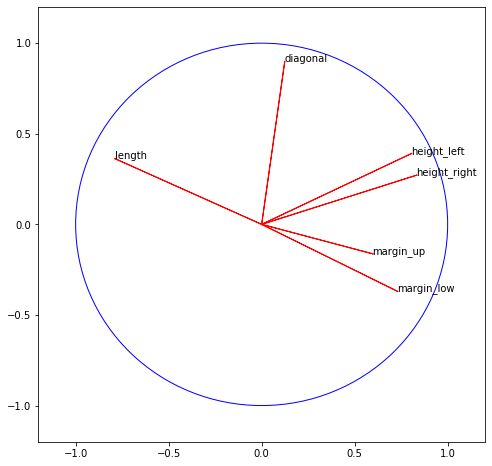

In [77]:
# coordonnées des variables
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2, data.columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='r')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=plt.Circle((0,0), radius=1, color='b', fill=False)
ax.add_patch(c)
plt.show()

# Représentation des individus

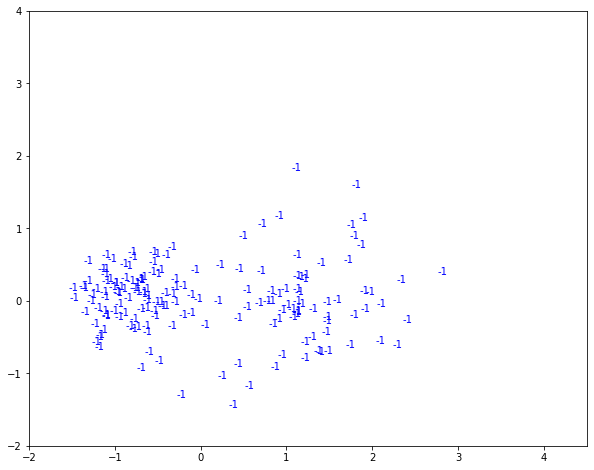

In [91]:
plt.figure(figsize=(10,8))
for i, j, nom in zip(C[:,0], C[:,1], notes['is_genuine']):
    color = "red" if nom == "0" else "blue"
    plt.text(i, j, nom, color=color)
plt.axis((-2,4.5,-2,4))  
plt.show()

# Classification des variables

QUESTION Les classes de variables sont-elles cohérentes avec l'interprétataion des axes?


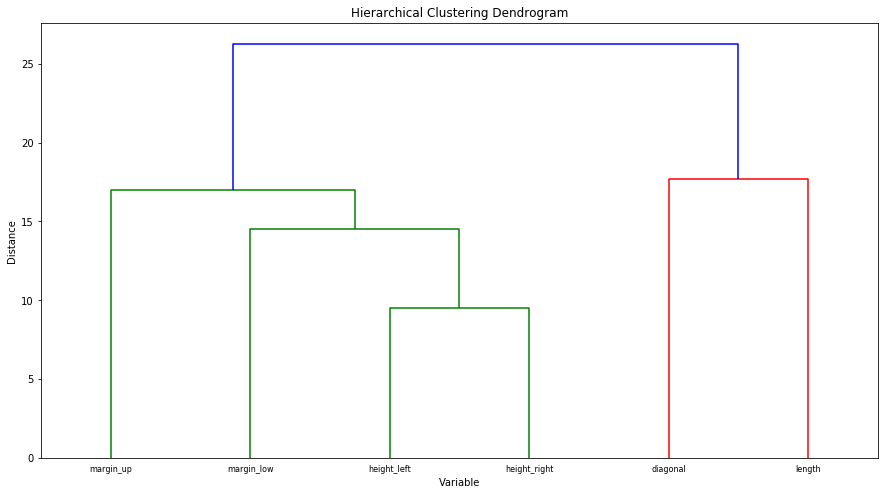

In [79]:
# Stratégie utilisée pour aider à l'interprétation du plan principal 
# lorsque le nombre de variables est important
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(data.T, 'ward')
plt.figure(figsize=(15, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Variable')
plt.ylabel('Distance')
dendrogram(Z,leaf_font_size=8.,labels=data.columns)
plt.show()

# Autre Méthode

In [80]:
# choix du nombre de composantes à calculer
n_comp = 5

In [81]:
# import de l'échantillon
data = notes[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']]

In [82]:
# selection des colonnes à prendre en compte dans l'ACP
data_pca = data[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']]

In [83]:
# préparation des données pour l'ACP
#data_pca = data_pca.fillna(data_pca.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values
names = data.index # ou data.index pour avoir les intitulés
features = data.columns

In [84]:
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)#ici


In [85]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [97]:
D = pca.fit(data).transform(data)
D

array([[-3.02107700e-03, -3.75136635e-01,  9.21544369e-01,
        -6.23627661e-01,  6.31168624e-01],
       [-1.01124014e+00,  6.93762886e-02, -3.33843994e-01,
        -7.02035271e-02,  1.81915868e-01],
       [-1.23951059e+00, -5.37303477e-01, -2.01593698e-01,
         1.94062924e-02, -4.36078620e-03],
       [-1.41689723e+00,  1.65429601e-01, -1.56215891e-01,
        -1.49500851e-01, -2.64483334e-02],
       [-7.42004492e-01, -9.70984310e-01, -3.08273792e-01,
         5.96162543e-01,  2.96492739e-01],
       [-3.85559308e-01, -3.86870406e-01,  1.02027191e+00,
         1.26885714e-01,  1.69736610e-01],
       [-1.06824352e+00,  1.56141619e-01,  5.40864294e-02,
         4.24825649e-01, -1.50186797e-01],
       [-1.36702835e+00,  5.07083124e-01, -4.98523506e-01,
        -1.97482744e-01, -1.05762274e-02],
       [-1.16430335e+00,  1.67598470e-02, -1.87635280e-01,
        -5.03182824e-02, -4.20674591e-01],
       [ 1.53427251e-01, -4.06840675e-02,  3.86651013e-01,
         5.03978173e-02

# Éboulis des valeurs propres

Nous allons dans un premier temps faire un éboulis des valeurs propre, pour voir combien d'axes étudier.

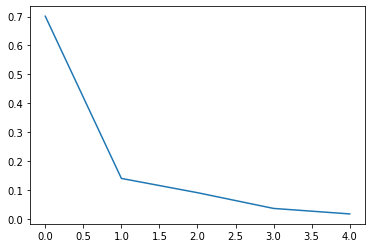

In [87]:
# Eboulis des valeurs propres
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.show()

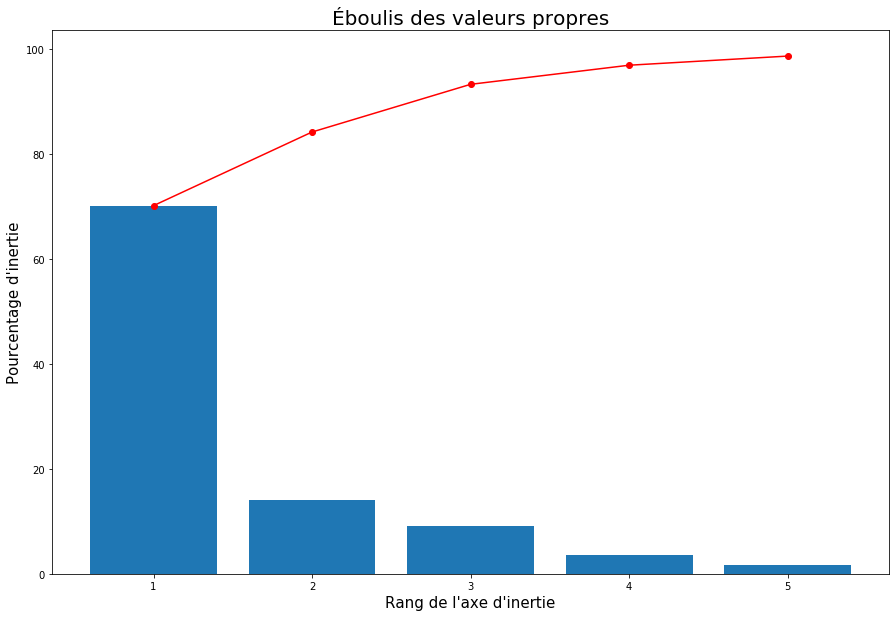

In [105]:
plt.figure(figsize=(15,10))

scree = pca.explained_variance_ratio_*100

plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')

plt.xlabel("Rang de l'axe d'inertie", fontsize=15)
plt.ylabel("Pourcentage d'inertie", fontsize=15)
plt.title("Éboulis des valeurs propres",fontsize=20)

plt.show()

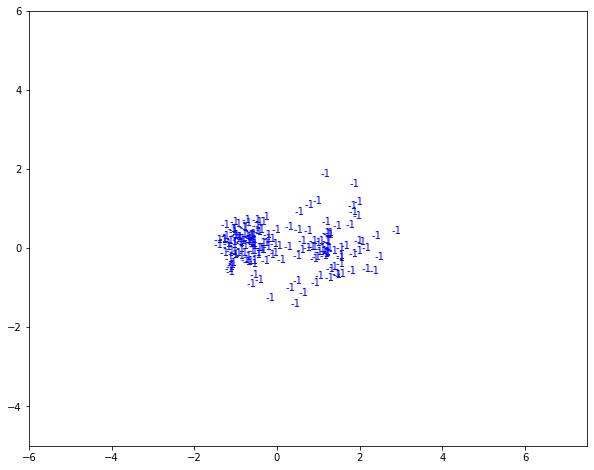

In [98]:
plt.figure(figsize=(10,8))
for i, j, nom in zip(C[:,0], C[:,1], notes['is_genuine']):
    color = "red" if nom == "True" else "blue"
    plt.text(i, j, nom, color=color)
plt.axis((-6,7.5,-5,6))  
plt.show()

In [106]:
scree = pd.DataFrame(scree.round(3), index=('Axe 1','Axe 2','Axe 3','Axe 4','Axe 5'))
scree.columns = ['Inertie %']
scree

,Inertie %
Axe 1,70.119
Axe 2,14.020
Axe 3,9.083
Axe 4,3.638
Axe 5,1.740


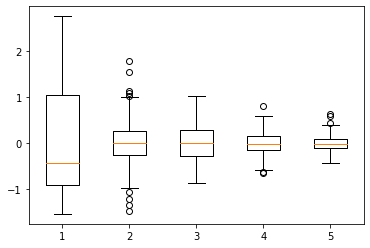

In [100]:
# Diagrammes boîte des composantes principales
plt.figure()
plt.boxplot(C[:,0:20])
plt.show()

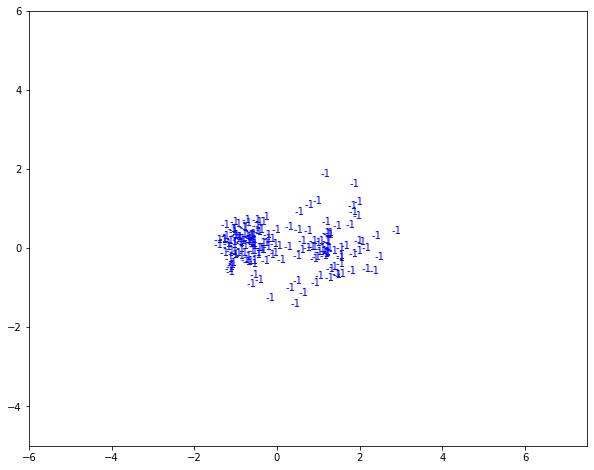

In [102]:
plt.figure(figsize=(10,8))
for i, j, nom in zip(C[:,0], C[:,1], notes['is_genuine']):
    color = "red" if nom == "1" else "blue"
    plt.text(i, j, nom, color=color)
plt.axis((-6,7.5,-5,6))  
plt.show()

# Cercle de corrélation des variables.

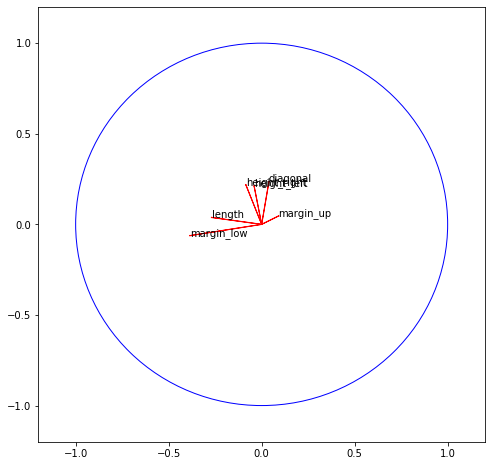

In [103]:
# coordonnées des variables
coord1=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
coord2=pca.components_[2]*np.sqrt(pca.explained_variance_[2])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2, data.columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='r')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=plt.Circle((0,0), radius=1, color='b', fill=False)
ax.add_patch(c)
plt.show()

In [99]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

NameError: name 'display_circles' is not defined

## Partie 2 : PREDICTION

Effectuer la prédiction de nouveaux billets via un algorithme que vous allez mettre en place (kmeans? regression logistique? A vous de voir).  
Si besoin, je vous fournirai un nouveau jeu de données de billets afin que vous prédisiez s'ils sont vrais ou faux et qu'on valide ensuite !

# Régression logistique

Dans cette partie, nous allons nous concentrer sur la partie dans laquelle le programme fera le choix de l'authenticité du billet. Nous allons utiliser une régression logistique au vu de la classification.

In [114]:


from sklearn.linear_model import LogisticRegression
cols = ['diagonal','height_left','height_right','margin_low','margin_up','length']
X = notes[cols]
y = notes.is_genuine

logistic = LogisticRegression()
logistic.fit(X,y)



ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1

In [ ]:
.is_genuine